## This notebook is currently used for saving best models based on their IoU performance on the segmented validation and test data (22.03.22)

In [1]:
# Fix seeds for random numbers first!

seed_value=1

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
#session_conf = tensorflow.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tensorflow.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import sys
import os
import cv2
import json
import PIL
import numpy as np
from PIL import ImageOps, ImageDraw, ImageFont
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from collections import Counter
from skimage.transform import resize
import sklearn
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, jaccard_score, f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve

In [3]:
# tensorflow imports
import mltb.keras
from numba import cuda
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import VGG19, VGG16, ResNet50, EfficientNetB7
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

In [29]:
PARENT_DIR = "../../../"
JSON_DIR = os.path.join(PARENT_DIR, "labels/olivine_polygon_label_files/")
ROOT_DIR = os.path.join(PARENT_DIR, "Input_Data/processed_img_data/Olivine_Images/")
IMAGE_SIZE = (224,224)
json_files = os.listdir(JSON_DIR)
true_label_folder = os.path.join(PARENT_DIR, "Labels/voc_data/SegmentationClass")
saved_model_path = os.path.join(PARENT_DIR, 'Output_Data/saved_models/')

## Define Callbacks and Metrics

In [4]:
if not os.path.exists('./saved_models'):
    os.makedirs('./saved_models')
if not os.path.exists('./saved_models/checkpoints'):
    os.makedirs('./saved_models/checkpoints')
# Callback Definition
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('./saved_models/checkpoints/base_model.h5',
                                                 monitor='val_loss', 
                                                 mode='auto', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./saved_models/logs', profile_batch=0)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)

In [5]:
class CalcAndLogF1Score(tf.keras.callbacks.Callback):
    def __init__(self, valid_data_generator):
        super(CalcAndLogF1Score, self).__init__()
        self.validation_data = valid_data_generator

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_steps_per_epoch = np.math.ceil(self.validation_data.samples / self.validation_data.batch_size)
        
        predict = self.model.predict(self.validation_data, steps=val_steps_per_epoch)
        val_predict = [1 * (x[0]>=0.5) for x in predict]
        
        val_targ = self.validation_data.classes

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(f" — val_f1: {_val_f1:.4f} — val_precision: {_val_precision:.4f} — val_recall: {_val_recall:.4f}")
        return

In [6]:
class JaccardScoreCallback(tf.keras.callbacks.Callback):
    """Computes the Jaccard score and logs the results to TensorBoard."""

    def __init__(self, model, valid_data_generator, log_dir):
        self.model = model
        self.validation_data = valid_data_generator
        self.keras_metric = tf.keras.metrics.Mean("jaccard_score")
        self.epoch = 0
        self.summary_writer = tf.summary.create_file_writer(os.path.join(log_dir, model.name))

    def on_epoch_end(self, batch, logs=None):
        self.epoch += 1
        self.keras_metric.reset_states()
        
        val_steps_per_epoch = np.math.ceil(self.validation_data.samples/self.validation_data.batch_size)
        
        predict = self.model.predict(self.validation_data, steps=val_steps_per_epoch)
        val_predict = [1 * (x[0]>=0.5) for x in predict]
        
        val_targ = self.validation_data.classes
        
        jaccard_value = jaccard_score(val_predict, val_targ, average=None)
        self.keras_metric.update_state(jaccard_value)
        self._write_metric(self.keras_metric.name, self.keras_metric.result().numpy().astype(float))

    def _write_metric(self, name, value):
        with self.summary_writer.as_default():
            tf.summary.scalar(name, value, step=self.epoch,)
            self.summary_writer.flush()

In [7]:
class F1_Metric(tf.keras.callbacks.Callback):
    def __init__(self, model, valid_data_generator, filepath='./saved_models'):
        self.model = model
        self.validation_data = valid_data_generator
        self.file_path = filepath
                

    def on_train_begin(self, logs=None):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        
        # check if model already exists
        for fname in os.listdir(self.file_path):
            if fname.endswith('.h5'):
                self.best_val_f1 = float(fname.split('_')[-2])
                print(f"Previous f1_score: {self.best_val_f1}")
            else:
                self.best_val_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        val_steps_per_epoch = np.math.ceil(self.validation_data.samples/self.validation_data.batch_size)
        predict = self.model.predict(self.validation_data, steps=val_steps_per_epoch)
        val_predict = [1 * (x[0]>=0.5) for x in predict]
        val_targ = self.validation_data.classes
        
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f"_val_f1: {_val_f1:.4f}, _val_precision: {_val_precision:.4f}, _val_recall: {_val_recall:.4f}")
        print(f"max f1: {max(self.val_f1s):.4f}")
        if _val_f1 > self.best_val_f1:
            
            # check if model already exists
            for fname in os.listdir(self.file_path):
                if fname.endswith('.h5'):
                    if (_val_f1 > float(fname.split('_')[-2])):
                        os.remove(f"{self.file_path}/{fname}")
                        self.model.save(f"{self.file_path}/base_model_{_val_f1:.4f}_.h5", overwrite=True)
            
            self.best_val_f1 = _val_f1
            print(f"best f1: {self.best_val_f1:.4f}")
        else:
            print(f"val f1: {_val_f1:.4f}, but not the best f1")
        return

In [8]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [9]:
def reset_gpu_mem():# clear GPU memory
    K.clear_session()
    #cuda.select_device(0)
    #cuda.close()

## Define Grad-CAM methods


In [10]:
def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor # np.array()

In [11]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [12]:
def generate_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [13]:
def get_superimposed_gradcam_img(img, heatmap, cam_path="cam.jpg", alpha=0.8):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    img = img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)
    
    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    #show(superimposed_img)
    
    return superimposed_img

In [14]:
def cam_display(display, text, src_img, superimposed_img, img_name, preds):
    text = f'IMG_NAME: {img_name}\nPrediction: {preds}'
    images = [src_img, superimposed_img]
    
    widths, heights = zip(*(i.size for i in images))
    
    total_width = sum(widths)
    max_height = max(heights)

    new_img = PIL.Image.new('RGB', (total_width, max_height))
    
    x_offset = 0
    for im in images:
        new_img.paste(im, (x_offset,0))
        x_offset += im.size[0]
    new_img = ImageOps.expand(new_img, border=50, fill=(255,255,255))
    new_img = new_img.resize(tuple(i*2 for i in new_img.size), resample=PIL.Image.BOX)
    draw = ImageDraw.Draw(new_img)
    font = ImageFont.truetype("FONTS/arial.ttf", 40)
    if text:
        draw.text((10,0),text,(0,0,0),font=font)
    if display:
        show_img(new_img)
    new_img.save(f'./cam_images/{img_name}')

In [15]:
def cam_pipeline(ROOT_DIR, img_name, json_img, IMAGE_SIZE, model_loaded, last_conv_layer_name, display=True, text=True):
    img_path = os.path.join(ROOT_DIR, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    img = PIL.Image.fromarray(img)
    
    # Prepare image for class prediction
    img_array = get_img_array(img_path, size=IMAGE_SIZE)
    # Remove last layer's softmax
    model_loaded.layers[-1].activation = None
    
    # Print what the top predicted class is
    
    new_image = load_image(img_path, show=False)

    # check prediction
    # pred = model.predict(new_image)
    preds = model_loaded.predict(new_image)
    #print("Predicted:", decode_predictions(preds, top=1)[0])
    
    # Generate class activation heatmap
    heatmap = generate_gradcam_heatmap(img_array, model_loaded, last_conv_layer_name)
    
    if display:
        superimposed_img = get_superimposed_gradcam_img(img, heatmap)
        json_img = json_img.resize(IMAGE_SIZE, PIL.Image.ANTIALIAS)
        cam_display(display, text, json_img, superimposed_img, img_name, preds)
    return heatmap

In [16]:
def get_img_and_draw(ROOT_DIR, img_name, IMAGE_SIZE):
    img_path = os.path.join(ROOT_DIR, img_name)
    # print(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, IMAGE_SIZE)
    img = PIL.Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    return img, draw

In [17]:
def get_json_img_name(json_file_name):
    if ('_OLV' not in json_file_name):
        img_name = f"{json_file_name.split('.')[0]}_OLV.jpg"
    else:
        img_name = f"{json_file_name.split('.')[0]}.jpg"
    return img_name

In [18]:
def draw_json_polygons(img_name, json_file_name, ROOT_DIR, IMAGE_SIZE):    
    img, draw = get_img_and_draw(ROOT_DIR, img_name, IMAGE_SIZE)
    
    # Opening JSON file
    json_path = os.path.join(JSON_DIR, json_file_name)
    with open(json_path) as json_file:
        json_data = json.load(json_file)

    # iterate over all olivine polygons
    num_of_polygons = len(json_data['shapes'])
    for i in range(num_of_polygons): # iterate over different olivine crystals
        polygon_coordinates = [tuple(x) for x in json_data['shapes'][i]['points']]
        # print(polygon_coordinates)
        polygon_coordinates.append(polygon_coordinates[0]) # polygon needs to be closed
        for j in range(len(polygon_coordinates)-1): # iterate over coordinates of single crystal
            draw.line(polygon_coordinates[j] + polygon_coordinates[j+1], fill='red', width=3)
    return img

In [19]:
def calc_iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    #print(f"IoU score: {iou_score:.2f}")
    return iou_score

## Define Models

In [20]:
# define basic cnn model
def define_base_model_legacy(learn_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='last_conv_layer'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    # opt = SGD(lr=0.001, momentum=0.9)
    opt = Adam(learning_rate=learn_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# define basic cnn model
def define_base_model(learn_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='last_conv_layer'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    # opt = SGD(lr=0.001, momentum=0.9)
    opt = Adam(learning_rate=learn_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[METRICS])#metrics=['accuracy'])
    return model

In [22]:
# define cnn model
def define_vanilla_vgg_model(image_shape=(224, 224, 3), index=22):
    # load model
    model = VGG16(include_top=False, input_shape=image_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:#[:index]:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    #opt = SGD(lr=0.001, momentum=0.9)
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [23]:
def define_vgg_model(image_shape=(224, 224, 3), index=22):
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
    for layer in base_model.layers:
        layer.trainable = False
    # base_model.trainable = False # freeze layers from pretrained model

    model = Sequential()
    #model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output) # copy all layers from base_model
    model.add(Rescaling(1./255,input_shape = image_shape))
    for layer in base_model.layers[1:-1]: # loop through convolution layers
        model.add(layer)
    model.add(base_model.get_layer('block5_pool')) # add final maxpooling2D layer
    model.add(Flatten())
    model.add(Dense(256,activation=('relu'))) 
    model.add(Dropout(.2))
    model.add(Dense(128,activation=('relu')))
    model.add(Dropout(.2))
    
    # Final layer
    model.add(Dense(1,activation=('sigmoid'),name="activation_1"))
    
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [31]:
# run the test harness for evaluating a model
def run_test_harness(model_name='base', epochs=50, batch_size=32, index=22, verbose=1):
    # define model
    if model_name == 'base':
        model = define_base_model_legacy()
    elif model_name == 'vgg':
        model = define_vanilla_vgg_model()
    
    # create data generators
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       #rotation_range=40,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2,
                                       #shear_range=0.2,
                                       #zoom_range=0.2,
                                       #brightness_range=[0.1,1],
                                       #horizontal_flip=True,
                                       #fill_mode='nearest'
                                      )
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    # prepare iterators
    train_generator = train_datagen.flow_from_directory(
                                                 os.path.join(PARENT_DIR, 'Input_Data/processed_img_data/generator_input_data/thin_section_dataset/train/'),
                                                 class_mode='binary',
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 target_size=(224, 224))
    
    val_generator = val_datagen.flow_from_directory(
                                               os.path.join(PARENT_DIR, 'Input_Data/processed_img_data/generator_input_data/thin_section_dataset/validation/'),
                                               class_mode='binary', 
                                               color_mode='rgb',
                                               batch_size=batch_size, 
                                               target_size=(224, 224))
    
    # calculate class weights
    counter = Counter(train_generator.classes)
    max_val = float(max(counter.values()))
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
    
    ### Debug info ###
    print(f"\nClasses: {train_generator.class_indices}")
    print(f"Class Weights: {class_weights}")
    print(f"Class Distribution: {dict(counter)}\n")
    # fit model
    history = model.fit(train_generator, 
                        steps_per_epoch=len(train_generator), 
                        validation_data=val_generator, 
                        validation_steps=len(val_generator),
                        class_weight=class_weights,
                        epochs=epochs, 
                        verbose=verbose,
                        callbacks=[
                            #F1_Metric(model, val_generator),
                            #JaccardScoreCallback(model, val_generator, './saved_models/logs'),
                            #mltb.keras.BinaryClassifierMetricsCallback(val_generator, val_generator.classes, 1),
                            #CalcAndLogF1Score(valid_data_generator=val_generator),
                            #early_stopping,
                            tensorboard_callback,
                        ])
    
    return model, history

## Train Base Model

In [33]:
model_name = 'base'
last_conv_layer_name = "last_conv_layer"

# model_name = 'vgg'
# last_conv_layer_name = 'block5_conv3'

heatmap_size = (14,14) # for base model
# heatmap_size = (56,56) # for VGG model

iou_model_path = os.path.join(saved_model_path, model_name)
for i in range(1):
    model, history = run_test_harness(model_name=model_name, batch_size=32, epochs=10, verbose=1)
    iou_scores = []
    for json_file_name in json_files:
        img_name = get_json_img_name(json_file_name)
        image_id = "_".join(img_name.split('_')[:3])
        json_img = draw_json_polygons(img_name, json_file_name, ROOT_DIR, IMAGE_SIZE)
        pred_heatmap = cam_pipeline(ROOT_DIR, img_name, json_img, IMAGE_SIZE, model, last_conv_layer_name, display=False, text=False)
        predicted_binary_heatmap = np.where(pred_heatmap > 0.01, 1, 0)
        heatmap_size = predicted_binary_heatmap.shape
        print(heatmap_size)
        
        # search for corresponding labeled .npy file:
        for file in os.listdir(true_label_folder):
            if image_id in file:
                ground_truth_heatmap = np.load(os.path.join(true_label_folder, file))
                ground_truth_heatmap = resize(ground_truth_heatmap, heatmap_size)
                iou_score = calc_iou_score(ground_truth_heatmap, predicted_binary_heatmap)
                iou_scores.append(iou_score)
    
    mean_iou = np.mean(iou_scores)
    current_best_iou = 0
    # check if a model already exists and get it's IoU score
    #for fname in os.listdir(iou_model_path):
    #    if fname.endswith('.h5'):
    #        current_best_iou = float(fname.split('_')[-2])
    print(f"Calculated mean IoU: {mean_iou:.4f}")
    #print(f"IoU from saved model: {current_best_iou}")
    #if mean_iou > current_best_iou:
    #    os.remove(f"{iou_model_path}/{fname}")
    #    model.save(f"{iou_model_path}/{model_name}_model_iou_{mean_iou:.4f}_.h5", overwrite=True)
    #    print(f"Model with updated IoU has been saved.")
    #else:
    #    print("No Model update.")
    #reset_gpu_mem()

Found 483 images belonging to 2 classes.
Found 103 images belonging to 2 classes.

Classes: {'non-olivine': 0, 'olivine': 1}
Class Weights: {0: 1.0, 1: 3.025}
Class Distribution: {0: 363, 1: 120}

Epoch 1/10
16/16 [==============================] - 4s 274ms/step - loss: 32.3086 - accuracy: 0.5818 - val_loss: 0.5845 - val_accuracy: 0.7573
Epoch 2/10
16/16 [==============================] - 3s 187ms/step - loss: 1.0382 - accuracy: 0.7060 - val_loss: 0.6576 - val_accuracy: 0.5437
Epoch 3/10
16/16 [==============================] - 3s 200ms/step - loss: 0.9792 - accuracy: 0.7267 - val_loss: 0.6334 - val_accuracy: 0.5825
Epoch 4/10
16/16 [==============================] - 3s 188ms/step - loss: 0.9236 - accuracy: 0.7288 - val_loss: 0.6172 - val_accuracy: 0.5922
Epoch 5/10
16/16 [==============================] - 3s 190ms/step - loss: 0.8921 - accuracy: 0.7039 - val_loss: 0.6141 - val_accuracy: 0.5922
Epoch 6/10
16/16 [==============================] - 3s 189ms/step - loss: 0.8241 - accuracy:

In [40]:
vgg_model, vgg_history = run_test_harness(model_name='vgg', batch_size=32, epochs=60, verbose=1)

Found 483 images belonging to 2 classes.
Found 103 images belonging to 2 classes.

Classes: {'non-olivine': 0, 'olivine': 1}
Class Weights: {0: 1.0, 1: 3.025}
Class Distribution: {0: 363, 1: 120}

Epoch 1/60
16/16 [==============================] - 7s 419ms/step - loss: 2.6488 - accuracy: 0.5880 - val_loss: 0.6380 - val_accuracy: 0.8058
Epoch 2/60
16/16 [==============================] - 4s 233ms/step - loss: 1.1491 - accuracy: 0.7598 - val_loss: 2.3312 - val_accuracy: 0.3689
Epoch 3/60
16/16 [==============================] - 4s 234ms/step - loss: 0.8988 - accuracy: 0.7723 - val_loss: 0.8782 - val_accuracy: 0.6796
Epoch 4/60
16/16 [==============================] - 4s 232ms/step - loss: 0.4917 - accuracy: 0.8634 - val_loss: 0.5636 - val_accuracy: 0.8252s: 0.2941 
Epoch 5/60
16/16 [==============================] - 4s 230ms/step - loss: 0.4615 - accuracy: 0.8861 - val_loss: 0.5112 - val_accuracy: 0.8252
Epoch 6/60
16/16 [==============================] - 4s 232ms/step - loss: 0.1709 - 

Epoch 57/60
16/16 [==============================] - 4s 226ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.6001 - val_accuracy: 0.8350
Epoch 58/60
16/16 [==============================] - 4s 265ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.6120 - val_accuracy: 0.8350
Epoch 59/60
16/16 [==============================] - 3s 218ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.6078 - val_accuracy: 0.8350
Epoch 60/60
16/16 [==============================] - 4s 244ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.6149 - val_accuracy: 0.8350


In [75]:
vgg_model.save("./saved_models/my_awesome_test_vgg.h5", overwrite=True)

## Model Evaluation

In [31]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='orange')
    plt.legend(['train', 'val'])
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue')
    plt.plot(history.history['val_accuracy'], color='orange')
    plt.legend(['train', 'val']) 
    
    plt.subplots_adjust(top=1.6, right=1.2)
    
    plt.show()

In [32]:
def show_confusion_matrix(model, test_generator, batch_divisor=1):    
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    predicted_classes = [1 * (x[0]>=0.5) for x in predictions]
    
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys()) 
    
    cm = confusion_matrix(true_classes, predicted_classes)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report) 

In [33]:
def evaluate_model(model, history, verbose=1):
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory('thin_section_dataset/test/',
                                               class_mode='binary',
                                               color_mode='rgb',
                                               target_size=(224, 224),
                                               batch_size=1,
                                               shuffle=False,)
    # calculate test set accuracy
    _, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
    print('\nAccuracy on test set: %.3f' % (acc * 100.0))
    
    if verbose:
        # plot learning curves
        summarize_diagnostics(history)

        # plot confusion matrix
        show_confusion_matrix(model, test_generator)
    
    return acc

Found 104 images belonging to 2 classes.
104/104 [==============================] - 1s 7ms/step - loss: 0.5750 - accuracy: 0.6346

Accuracy on test set: 63.462


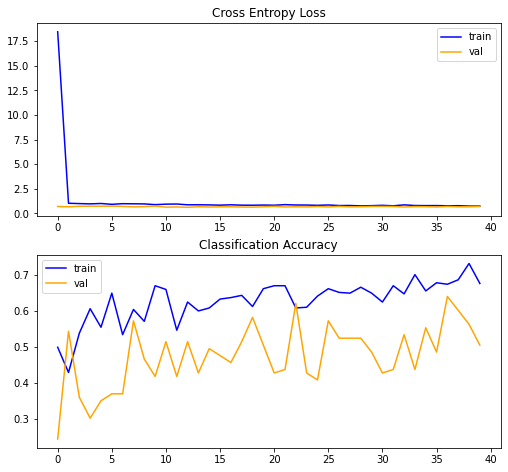

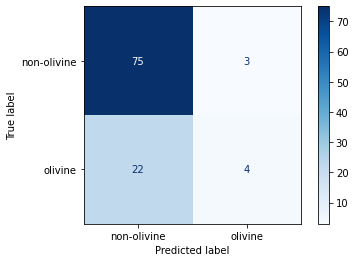

              precision    recall  f1-score   support

 non-olivine       0.77      0.96      0.86        78
     olivine       0.57      0.15      0.24        26

    accuracy                           0.76       104
   macro avg       0.67      0.56      0.55       104
weighted avg       0.72      0.76      0.70       104



In [34]:
accuracy = evaluate_model(model, history)